# The Analysis of The Best MLB Umpires

## Introduction

Here, I'm going to analyze which umpire of MLB performed best through 2015-2022.

The dataset used here 'mlb-umpire-scorecard.csv' is from the following link.  
https://www.kaggle.com/datasets/mattop/mlb-baseball-umpire-scorecards-2015-2022

### Define common function

In [1748]:
import psycopg2
from psycopg2 import sql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Ignore the warning
warnings.filterwarnings("ignore", category=UserWarning, message=".*SQLAlchemy.*")

# Common function to get connection to DB
def get_connection():
    db_config = {
    "dbname": "baseball",
    "user": "postgres",
    "password": "postgres",
    "host": "localhost",
    "port": "5432",
    }

    try:
        # Connect to DB
        conn = psycopg2.connect(**db_config)
        return conn
    except psycopg2.Error as e:
        print("Error: ", e)
        return None

### Data setup

In [1749]:
table_name = "umpire_scorecard"

try:
    conn = get_connection()
    cur = conn.cursor()

    # Drop umpire_scorecard table
    cur.execute(
        sql.SQL(
            """
            DROP TABLE IF EXISTS {}
            """
        ).format(sql.Identifier(table_name))
    )

    # Create umpire_scorecard table
    cur.execute(
        sql.SQL(
            """
        CREATE TABLE {} (
            id INTEGER PRIMARY KEY,
            date DATE,
            umpire VARCHAR(255),
            home VARCHAR(50),
            away VARCHAR(50),
            home_team_runs INTEGER,
            away_team_runs INTEGER,
            pitches_called INTEGER,
            incorrect_calls INTEGER,
            expected_incorrect_calls FLOAT,
            correct_calls INTEGER,
            expected_correct_calls FLOAT,
            correct_calls_above_expected FLOAT,
            accuracy FLOAT,
            expected_accuracy FLOAT,
            accuracy_above_expected FLOAT,
            consistency FLOAT,
            favor_home FLOAT,
            total_run_impact FLOAT
        );
        """
        ).format(sql.Identifier(table_name))
    )

    # Insert data
    file = open("mlb-umpire-scorecard.csv", mode="r", encoding="utf-8")

    cur.copy_expert(
        sql.SQL(
            """
            COPY {}
            FROM STDIN
            WITH CSV HEADER
            NULL AS 'ND'
            """
        ).format(sql.Identifier(table_name)),
        file,
    )

    # Commit the changes
    conn.commit()

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

Display the head of the inserted data

In [1750]:
try:
    conn = get_connection()    
    query = sql.SQL("SELECT * FROM {};").format(sql.Identifier(table_name)).as_string(conn)
    data = pd.read_sql_query(query, conn)
    print(data.head())

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

   id        date           umpire home away  home_team_runs  away_team_runs  \
0   1  2022-11-05  Lance Barksdale  HOU  PHI               4               1   
1   2  2022-11-03     Jordan Baker  PHI  HOU               2               3   
2   3  2022-11-02     Tripp Gibson  PHI  HOU               0               5   
3   4  2022-11-01     Dan Iassogna  PHI  HOU               7               0   
4   5  2022-10-29       Pat Hoberg  HOU  PHI               5               2   

   pitches_called  incorrect_calls  expected_incorrect_calls  correct_calls  \
0           124.0              4.0                      10.0          120.0   
1           149.0              6.0                       7.4          143.0   
2           124.0              7.0                       7.1          117.0   
3           140.0              5.0                       6.0          135.0   
4           129.0              0.0                       8.7          129.0   

   expected_correct_calls  correct_calls_abo

## Who's the best umpire?

How do we determine if the umpire is trustful or not?  
Here, I'm going to define the best umpire based on the following insight.  
1. Accuracy
2. Consistency
3. Accurate Above Expected(Performed better than the average umpire)
4. With Less Team Bias
5. Less Impact on Games

First, let's check the distribution of the number of games each umpire judged  
so that we can determine the smallest count to define who the best umpire is.

In [1751]:
try:
    conn = get_connection()
    query = (
        sql.SQL(
            """
            SELECT umpire, 
                COUNT(id) as game_count
            FROM {}
            GROUP BY umpire;
            """
        )
        .format(sql.Identifier(table_name))
        .as_string(conn)
    )
    data = pd.read_sql_query(query, conn)

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

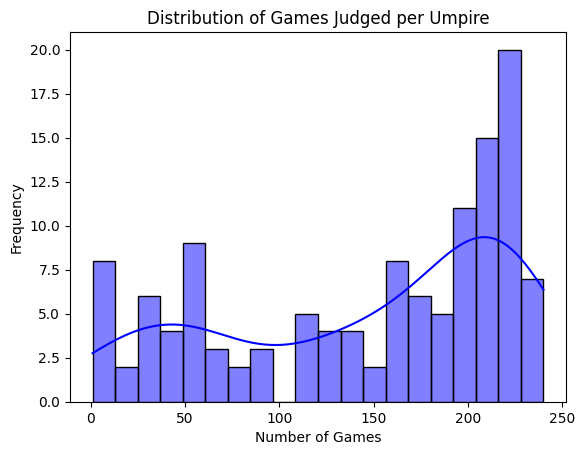

In [1752]:
sns.histplot(data['game_count'], bins=20, kde=True, color='blue')
plt.title('Distribution of Games Judged per Umpire')
plt.xlabel('Number of Games')
plt.ylabel('Frequency')
plt.show()

So here, I define the standard number of games to be cutoff as 100 because around there the distribution is at its lowest point.  
Now, I analyze the umpires only who judged over 100 games.

## 1. The Most Accurate Umpires

Top 10 Umpires by Average Accuracy

In [1753]:
try:
    conn = get_connection()
    query = (
        sql.SQL(
            """
            SELECT umpire, 
                AVG(accuracy) as avg_accu
            FROM {}
            GROUP BY umpire
            HAVING COUNT(id) > 100
            ORDER BY avg_accu DESC
            ;
            """
        )
        .format(sql.Identifier(table_name))
        .as_string(conn)
    )
    data = pd.read_sql_query(query, conn)

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

In [1754]:
data[["umpire", "avg_accu"]].iloc[:10].reset_index(drop=True)

,umpire,avg_accu
0,John Libka,94.956667
1,Jeremie Rehak,94.630894
2,Jansen Visconti,94.567669
3,Will Little,94.130622
4,Pat Hoberg,93.916818
5,Tripp Gibson,93.630493
6,Ben May,93.622283
7,Lance Barksdale,93.437557
8,Nick Mahrley,93.435345
9,Alan Porter,93.307339


In [1755]:
# Use this later
avg_accu_data = data

## 2. The Most Consistent Umpires

Top 10 Umpires by Average Consistency

In [1756]:
try:
    conn = get_connection()
    query = (
        sql.SQL(
            """
            SELECT umpire, 
                AVG(consistency) as avg_cons
            FROM {}
            GROUP BY umpire
            HAVING COUNT(id) > 100
            ORDER BY avg_cons DESC
            ;
            """
        )
        .format(sql.Identifier(table_name))
        .as_string(conn)
    )
    data = pd.read_sql_query(query, conn)

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

In [1757]:
data[["umpire", "avg_cons"]].reset_index(drop=True).head(10)

,umpire,avg_cons
0,Jansen Visconti,93.996992
1,John Libka,93.857500
2,Pat Hoberg,93.815455
3,Will Little,93.695694
4,Ben May,93.683152
5,Bruce Dreckman,93.644444
6,Jeremie Rehak,93.642276
7,John Tumpane,93.609390
8,Lance Barksdale,93.598190
9,Eric Cooper,93.558451


In [1758]:
# Use this later
avg_cons_data = data

The umpires listed above seem to be mostly the same people.  
Is there a relationship between accuracy and consistency?

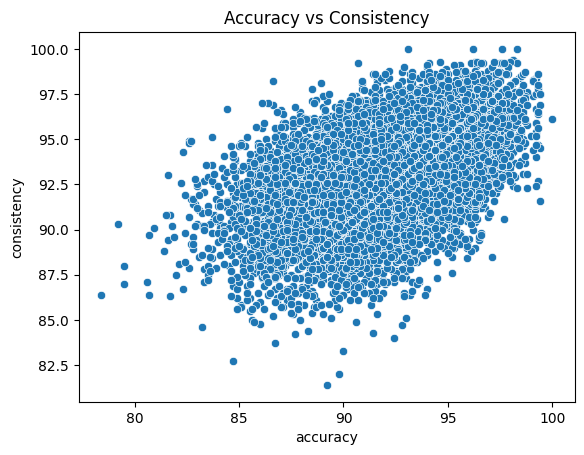

In [1759]:
try:
    conn = get_connection()
    query = (
        sql.SQL(
            """
            SELECT accuracy, consistency
            FROM {};
            """
        )
        .format(sql.Identifier(table_name))
        .as_string(conn)
    )
    acc_cons_data = pd.read_sql_query(query, conn)
    sns.scatterplot(data=acc_cons_data, x="accuracy", y="consistency")
    plt.title("Accuracy vs Consistency")
    plt.show()

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

According to the chart, it seems that they are basically proportional to each other.

## 3. The Umpires Who Performed Accurately More Than Expected

Top 10 umpires who performed accurately more than expected

In [1760]:
try:
    conn = get_connection()
    query = (
        sql.SQL(
            """
            SELECT umpire, 
                AVG(accuracy_above_expected) as avg_accu_abv_exp
            FROM {}
            GROUP BY umpire
            HAVING COUNT(id) > 100 
            ORDER BY avg_accu_abv_exp DESC
            ;
            """
        )
        .format(sql.Identifier(table_name))
        .as_string(conn)
    )
    data = pd.read_sql_query(query, conn)
    # Use this later
    avg_accu_abv_exp_data = data

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

In [1761]:
data[["umpire", "avg_accu_abv_exp"]].reset_index(drop=True).head(10)

,umpire,avg_accu_abv_exp
0,Will Little,1.941148
1,John Libka,1.753333
2,Jeremie Rehak,1.600000
3,Pat Hoberg,1.512273
4,Jansen Visconti,1.441353
5,Lance Barksdale,1.214027
6,Eric Cooper,1.153521
7,Tripp Gibson,1.102691
8,Alan Porter,1.043578
9,Ben May,1.014674


## 4. The Umpires With The Least Team Bias

Here, we have the accuracy, consistency, and favor_home(home tean bias).  
First, I want to confirm if there is a relationship between accuracy and favor_home, also between consistency and favor_home.

In [1762]:
try:
    conn = get_connection()
    query = (
        sql.SQL(
            """
            SELECT accuracy, consistency, favor_home
            FROM {};
            """
        )
        .format(sql.Identifier(table_name))
        .as_string(conn)
    )
    data = pd.read_sql_query(query, conn)

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

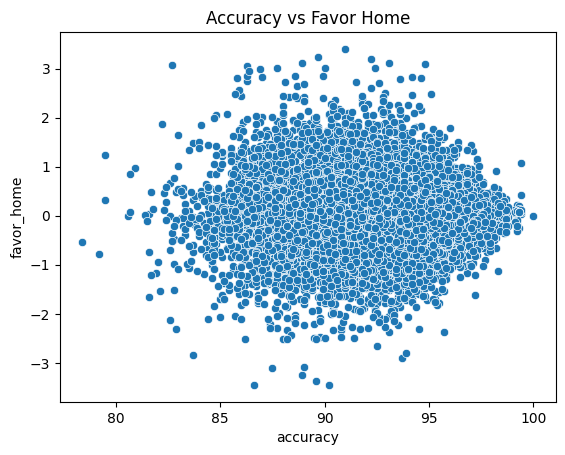

In [1763]:
sns.scatterplot(data=data, x="accuracy", y="favor_home")
plt.title("Accuracy vs Favor Home")
plt.show()

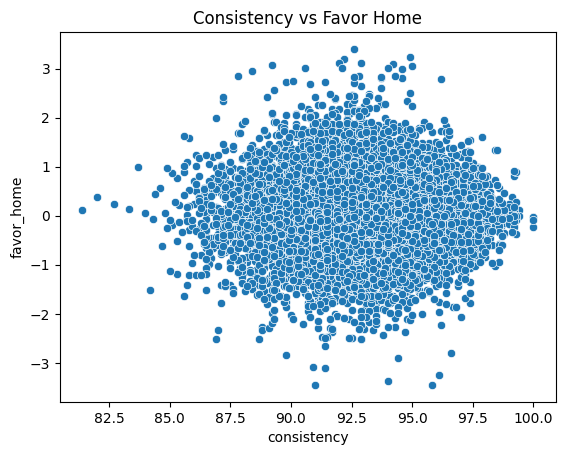

In [1764]:
sns.scatterplot(data=data, x="consistency", y="favor_home")
plt.title("Consistency vs Favor Home")
plt.show()

There seems to be no strong relationships between them.  
Then, let's see the distribution of favor_home.

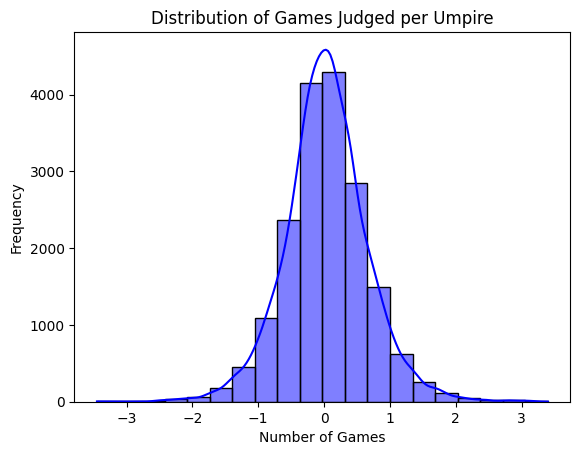

In [1765]:
try:
    conn = get_connection()
    query = (
        sql.SQL(
            """
            SELECT favor_home
            FROM {}
            ;
            """
        )
        .format(sql.Identifier(table_name))
        .as_string(conn)
    )
    data = pd.read_sql_query(query, conn)
    sns.histplot(data['favor_home'], bins=20, kde=True, color='blue')
    plt.title('Distribution of Games Judged per Umpire')
    plt.xlabel('Number of Games')
    plt.ylabel('Frequency')
    plt.show()

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

In [1766]:
try:
    conn = get_connection()
    query = (
        sql.SQL(
            """
            SELECT umpire, 
                AVG(favor_home) as avg_fav_home
            FROM {}
            GROUP BY umpire
            HAVING COUNT(id) > 100 
            ;
            """
        )
        .format(sql.Identifier(table_name))
        .as_string(conn)
    )
    data = pd.read_sql_query(query, conn)

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

As you can see, umpires basically judge fairly.

If the favor_home is close to zero, it means the umpire is judging fairly, with less home team bias.  
Here, we have the absolute difference between zero and the average favor_home, and ascendly sorted them.

In [1767]:
data['avg_fav_home_abs_diff_from_zero'] = (data['avg_fav_home'] - 0).abs()
data[["umpire", "avg_fav_home_abs_diff_from_zero"]].sort_values(
    by="avg_fav_home_abs_diff_from_zero", ascending=True
).reset_index(drop=True).head(10)

,umpire,avg_fav_home_abs_diff_from_zero
0,Mark Ripperger,0.000654
1,Dan Iassogna,0.000721
2,Jordan Baker,0.002149
3,Gary Cederstrom,0.003101
4,Angel Hernandez,0.003128
5,Jeff Nelson,0.004529
6,Chris Guccione,0.005446
7,Gerry Davis,0.005570
8,Chad Fairchild,0.005909
9,Ryan Blakney,0.010090


In [1768]:
# Use this later
avg_fav_home_data = data

## 5. The Umpires Who Impacted The Run of The Games The Least

An umpire shouldn't impact the run of the game.  
Here, we have the top 10 umpires who impacted the run of the game by their misjudgment the least.

In [1769]:
try:
    conn = get_connection()
    query = (
        sql.SQL(
            """
            SELECT umpire, 
                SUM(total_run_impact) as sum_ttl_run_imp
            FROM {}
            GROUP BY umpire
            HAVING COUNT(id) > 100
            ORDER BY sum_ttl_run_imp ASC
            ;
            """
        )
        .format(sql.Identifier(table_name))
        .as_string(conn)
    )
    data = pd.read_sql_query(query, conn)

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

In [1770]:
data[["umpire", "sum_ttl_run_imp"]].reset_index(drop=True).head(10)

,umpire,sum_ttl_run_imp
0,John Libka,129.59
1,Jeremie Rehak,139.70
2,Nick Mahrley,150.59
3,Ryan Additon,156.98
4,Jansen Visconti,160.91
5,Roberto Ortiz,171.02
6,Mike Everitt,185.37
7,Eric Cooper,200.58
8,Jeff Kellogg,201.33
9,Brian Gorman,204.92


In [1771]:
# Use this later
sum_ttl_run_imp_data = data

## Conclusion
### The most trustful and fair umpires

Now we have five list which shows the best umpires based on each element.  
1. The Most Accurate Umpires
2. The Most Consistent Umpires
3. The Umpires Who Performed Accurately More Than Expected
4. The Umpires With The Least Team Bias
5. The Umpires Who Impacted The Run of The Games The Least

Let's do the math and get the summary of the rank,   
which means that the smaller summary is, the better umpires they are.

In [1772]:
from functools import reduce


# Merge DataFrames
dfs = [
    avg_accu_data,
    avg_cons_data,
    avg_accu_abv_exp_data,
    avg_fav_home_data,
    sum_ttl_run_imp_data,
]

merged_data = reduce(
    lambda left, right: pd.merge(left, right, on="umpire", how="inner"), dfs
)

accuracy_rank = merged_data["avg_accu"].rank(method="min", ascending=False)
consistency_rank = merged_data["avg_cons"].rank(method="min", ascending=False)
accuracy_above_expected_rank = merged_data["avg_accu_abv_exp"].rank(
    method="min", ascending=False
)
favor_home_rank = merged_data["avg_fav_home_abs_diff_from_zero"].rank(
    method="min", ascending=True
)
run_impact_rank = merged_data["sum_ttl_run_imp"].rank(method="min", ascending=True)
rank_sum = (
    accuracy_rank
    + consistency_rank
    + accuracy_above_expected_rank
    + favor_home_rank
    + run_impact_rank
)

merged_data["accuracy_rank"] = accuracy_rank
merged_data["consistency_rank"] = consistency_rank
merged_data["accuracy_above_expected_rank"] = accuracy_above_expected_rank
merged_data["favor_home_rank"] = favor_home_rank
merged_data["run_impact_rank"] = run_impact_rank
merged_data["rank_sum"] = rank_sum

merged_data[
    [
        "umpire",
        "rank_sum",
        "accuracy_rank",
        "consistency_rank",
        "accuracy_above_expected_rank",
        "favor_home_rank",
        "run_impact_rank",
    ]
].sort_values(by="rank_sum").reset_index(drop=True).head(10)

,umpire,rank_sum,accuracy_rank,consistency_rank,accuracy_above_expected_rank,favor_home_rank,run_impact_rank
0,Jeremie Rehak,28.0,2.0,7.0,3.0,14.0,2.0
1,John Libka,33.0,1.0,2.0,2.0,27.0,1.0
2,Jansen Visconti,42.0,3.0,1.0,5.0,28.0,5.0
3,Ben May,65.0,7.0,5.0,10.0,29.0,14.0
4,Pat Hoberg,76.0,5.0,3.0,4.0,41.0,23.0
5,Mark Ripperger,80.0,14.0,14.0,11.0,1.0,40.0
6,Eric Cooper,80.0,24.0,10.0,7.0,31.0,8.0
7,John Tumpane,97.0,13.0,8.0,13.0,30.0,33.0
8,Will Little,98.0,4.0,4.0,1.0,71.0,18.0
9,Alan Porter,100.0,10.0,13.0,9.0,26.0,42.0


The umpires listed above are the top 10 umpires according to the analysis.